# Alternative ML Models with the CPAC_S01_S02_S03_05_31_20 dataset

## Libraries

In [21]:
import sklearn
assert sklearn.__version__ >= "0.21", "Use the conda_python3_latest kernel!"

# Standard library
import os
import re
import warnings

# Third party
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn import (dummy, linear_model, ensemble, neural_network,
                     metrics, preprocessing, pipeline, inspection, 
                     model_selection)

from IPython.display import display, Markdown

# Local
import utils

# matplotlib hackery
%matplotlib inline

## Load Dataset

In [2]:
df_orig = utils.load_dataset("s3://cpac/ORIG/CPAC_S01_S02_S03_05_31_20/CPAC10S_S01_S02_S03_06_01_20.csv")
df_orig.describe()

,M_Trial_Num,M_Mass,M_Mass_to_L5S1,M_sub_task_indices,M_sub_task_num,M_include_overall,M_Index,M_Sub,M_sub_task_num_overall,M_Index_overall,...,RWEO_03_04_00_00_INSOLE_LY_AP_threshF50_mm,RWEO_01_00_00_00_INSOLE_RFORCE_threshF50_N,RWEO_01_02_00_00_INSOLE_RX_ML_threshF50_mm,RWEO_01_02_00_00_INSOLE_RY_AP_threshF50_mm,RWEF_03_00_00_00_INSOLE_LFORCE_threshF50_BW,RWEF_03_04_00_00_INSOLE_LX_ML_threshF50_BH,RWEF_03_04_00_00_INSOLE_LY_AP_threshF50_BH,RWEF_01_00_00_00_INSOLE_RFORCE_threshF50_BW,RWEF_01_02_00_00_INSOLE_RX_ML_threshF50_BH,RWEF_01_02_00_00_INSOLE_RY_AP_threshF50_BH
count,596920.000000,596920.000000,450392.000000,596920.000000,596920.000000,596920.000000,596920.000000,596920.000000,596920.000000,596920.000000,...,509406.000000,594981.000000,506937.000000,506937.000000,594981.000000,509406.000000,509406.000000,594981.000000,506937.000000,506937.000000
mean,68.172854,10.576766,0.310355,295.212494,5.496341,0.782267,2850.599620,1.897787,235.306545,76305.094906,...,121.034549,357.312319,47.795679,135.603684,0.473457,0.028690,0.067842,0.487438,0.026754,0.075886
std,23.458992,5.960748,0.164044,234.100540,4.754427,0.412705,2708.406675,0.817537,121.308144,72015.333181,...,55.562888,283.629719,8.805979,53.366872,0.336114,0.005458,0.031498,0.354233,0.004836,0.030041
min,1.000000,0.000000,0.083662,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,-0.195016,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,49.000000,5.000000,0.154197,121.000000,1.000000,1.000000,603.000000,1.000000,132.000000,0.000000,...,75.000000,125.815000,44.110000,93.770000,0.173023,0.026911,0.041779,0.187174,0.024577,0.052399
50%,78.000000,10.000000,0.274311,250.000000,4.000000,1.000000,1954.000000,2.000000,250.000000,63184.500000,...,112.680000,313.860000,49.980000,133.750000,0.482852,0.029677,0.062232,0.481379,0.028043,0.073984
75%,85.000000,15.000000,0.457227,407.000000,8.000000,1.000000,4445.000000,3.000000,335.000000,137799.250000,...,168.120000,559.535000,53.710000,183.140000,0.726662,0.032168,0.093348,0.726368,0.029920,0.101509
max,96.000000,23.000000,0.701759,1866.000000,21.000000,1.000000,14119.000000,3.000000,452.000000,233105.000000,...,242.320000,1558.065000,71.260000,247.560000,1.949560,0.041882,0.140069,2.041016,0.041191,0.143098


## Associate column names

In [3]:
def _get_columns_with_prefix(df, prefix):
    columns = []
    for column in df.columns:
        if column.startswith(prefix):
            columns.append(column)
    return columns
    
def get_target_names(df):
    return _get_columns_with_prefix(df, "T_")

def get_meta_names(df):
    return _get_columns_with_prefix(df, "M_")    

## Clean-up dataset

- Remove samples based on `M_include_overall`

In [22]:
df = df_orig[df_orig["M_include_overall"] > 0]
print(f"Number of samples: {df.shape[0]} (before clean-up: {df_orig.shape[0]})")
print(f"Number of trials: {len(df['M_Trial_Name'].unique())} (before clean-up: {len(df_orig['M_Trial_Name'].unique())})")
print(f"Number of subjects: {len(df['M_Sub'].unique())}")

Number of samples: 307931 (before clean-up: 596920)
Number of trials: 127 (before clean-up: 141)
Number of subjects: 2


## Predictor configurations (recipes)

In [23]:
def predictor_short_name(predictor):
    return predictor[17:]

def predictor_sensor_number(predictor):
    return int(predictor[5:7])

def filter_predictors(all_predictors, patterns):
    if isinstance(patterns, str):
        patterns = (patterns,)
        
    predictors = []
    for predictor in all_predictors:
        for pattern in patterns:
            if pattern in predictor:
                predictors.append(predictor)
                break
    return predictors


feature_sets = {
#    "Recipe 1: Simulated Wearable - All Regular": 
#        filter_predictors(df.columns, "SWRF"),
#    
#    "Recipe 2: Simulated Wearable - All Regular & Exploratory": 
#        filter_predictors(df.columns, ("SWRF", "SWEF")),
    
    "Recipe 3: Real Wearable - All Regular": 
        filter_predictors(df.columns, "RWRF"),
    
    "Recipe 4: Real Wearable - All Regular & Exploratory": 
        filter_predictors(df.columns, ("RWRF", "RWEF")),
    
    "Recipe 5: Real Wearable - Insole Only":
        filter_predictors(
            filter_predictors(df.columns, ("RWRF", "RWEF")),
            ("03_00_00_00", "01_00_00_00", "03_04_00_00", "01_02_00_00", "01_03_00_00")
        ),
    
    "Recipe 6: Real Wearable - Trunk Orientatoin Only":
        filter_predictors(
            filter_predictors(df.columns, ("RWRF", "RWEF")),
            ("12_00_00_00",)
        ),
    
    "Recipe 7: Real Wearable - Insole & Trunk Orientation":
        filter_predictors(
            filter_predictors(df.columns, ("RWRF", "RWEF")),
            ("03_00_00_00", "01_00_00_00", "03_04_00_00", "01_02_00_00", "01_03_00_00", 
             "12_00_00_00", "01_03_12_00")
        ),
    
    "Recipe 8: Real Wearable - Insole & Hip Angles & Trunk Orientation":
        filter_predictors(
            filter_predictors(df.columns, ("RWRF", "RWEF")),
            ("03_00_00_00", "01_00_00_00", "03_04_00_00", "01_02_00_00", "01_03_00_00", 
             "12_00_00_00", "01_03_12_00",
             "05_06_00_00", "05_09_00_00", "06_00_00_00", "09_00_00_00", "05_12_00_00", "05_06_01_03", "05_09_01_03")
        ),
    
}

for feature_set_name, predictors in feature_sets.items():
    sensors = set(map(predictor_sensor_number, predictors))
    print(f"{feature_set_name}\n\tPredictors: {len(predictors)}, Sensors: {len(sensors)}\n")

Recipe 3: Real Wearable - All Regular
	Predictors: 166, Sensors: 10

Recipe 4: Real Wearable - All Regular & Exploratory
	Predictors: 201, Sensors: 10

Recipe 5: Real Wearable - Insole Only
	Predictors: 17, Sensors: 2

Recipe 6: Real Wearable - Trunk Orientatoin Only
	Predictors: 56, Sensors: 1

Recipe 7: Real Wearable - Insole & Trunk Orientation
	Predictors: 77, Sensors: 3

Recipe 8: Real Wearable - Insole & Hip Angles & Trunk Orientation
	Predictors: 133, Sensors: 6



## Train/Test configurations

In [24]:
test_selectors = {
#     "Subject 2 -> Subject 3": df["M_Sub"] == 3,
#     "Subject 3 -> Subject 2": df["M_Sub"] == 2,

    "Subject 1 & 2 -> Subject 3": df["M_Sub"] == 3,
    "Subject 1 & 3 -> Subject 2": df["M_Sub"] == 2,
    "Subject 2 & 3 -> Subject 1": df["M_Sub"] == 1,
#    "Subject 1 & 2 & 3 -> 5kg Test": df["M_Trial_Name"].str.match("S0[0-9]_5kg")
}

train_test_sets = {}
for test_selector_name, test_selector in test_selectors.items():
    df_train, df_test = df[~test_selector], df[test_selector]
    df_train, df_test = df_train.dropna(), df_test.dropna()
    train_test_sets[test_selector_name] = (df_train, df_test)
    print(f"{test_selector_name}: {len(df_train)}/{len(df_test)} "
          f"({len(df_train) / len(df):.1%}/{len(df_test) / len(df):.1%})")


Subject 2 -> Subject 3: 106652/67581 (34.6%/21.9%)
Subject 3 -> Subject 2: 67581/106652 (21.9%/34.6%)


## Train and evaluate boosted tree models

In [25]:
def train_model(X_train, y_train, regressor):
    model = pipeline.Pipeline([
        ('scaler', preprocessing.StandardScaler()),
        ('reg', regressor)
    ]).fit(X_train, y_train)
    return model
    
def evaluate_model(desc, model, X_test, y_test, show_plot=False, show_importance=False):
    y_test_pred = model.predict(X_test)
    
    # Quantitative results
    rmse = np.sqrt(metrics.mean_squared_error(y_test_pred, y_test))
    r2 = metrics.r2_score(y_test_pred, y_test)
    
    display(
        Markdown(
            "---\n"
            f"**Target**: {desc['target']}  \n"
            f"**Features**: {desc['feature_set']}  \n"
            f"**Train/Test**: {desc['train_test_set']}  \n"
            f"**Regressor**: {desc['regressor_name']}  \n"
            f"**R2={r2:.3f}**"
        )
    )
    
    if show_plot:
        ax = sns.jointplot(y_test, y_test_pred, alpha=0.1, s=1.0, color=desc["color"])
        ax.set_axis_labels("Actual Pelvis Moment", 'Predicted Pelvis Moment', fontsize=14)
        ax.ax_joint.grid()
        ax.ax_marg_x.set_title("Predictions")

        summary = '\n'.join((
            r"$\mathrm{RMSE}=%.2f$" % (rmse,),
            r"$\mathrm{R}^2=%.3f$" % (r2,)
        ))

        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        ax.ax_joint.text(0.05, 0.95, summary, transform=ax.ax_joint.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
        plt.show()
        
    if show_importance:
        feature_importances = inspection.permutation_importance(model, 
                                           X_test, 
                                           y_test, 
                                           n_repeats=5, n_jobs=-1)
        top_idxs = feature_importances.importances_mean.argsort()[::-1][:6]
        fig, ax = plt.subplots()
#         ax.boxplot(feature_importances.importances[top_idxs].T,
#                vert=False, labels=[predictor_short_name(X_test.columns[idx]) for idx in top_idxs])
        ax.barh(
            [predictor_short_name(X_test.columns[idx]) for idx in top_idxs], 
            feature_importances.importances_mean[top_idxs],
            color=desc["color"]
        )
        ax.set_title("Feature Importances")
        plt.show()
    
    return r2, pd.Series(y_test_pred, index=y_test.index)

def run_experiments(target_name, train_test_sets, regressor, regressor_name, color="steelblue"):
    warnings.filterwarnings('ignore')
    r2_scores = {}
    predictions = {}
    for train_test_set_name, (df_train, df_test) in train_test_sets.items():
        for feature_set_name, feature_names in feature_sets.items():
            desc = {"target": target_name, 
                    "feature_set": feature_set_name, 
                    "train_test_set": train_test_set_name,
                    "regressor_name": regressor_name,
                    "color": color
                   }
            model = train_model(df_train[feature_names], df_train[target_name], regressor)
            r2, prediction = evaluate_model(desc, 
                                            model, 
                                            df_test[feature_names], 
                                            df_test[target_name], 
                                            show_plot=True, 
                                            show_importance=False)
            
            # title = f'{target_name} from "{feature_set_name}" on "{train_test_set_name}"'
            # print(f"{title}\n\tR2={r2:.3f}")
            
            r2_scores.setdefault(train_test_set_name, {})[feature_set_name] = r2
            predictions.setdefault(train_test_set_name, {})[feature_set_name] = prediction
    warnings.filterwarnings('default')
    return r2_scores, predictions


## Estimating TF_Pelvis_Moment_X_BWBH with different regressors


---
**Target**: TF_Pelvis_Moment_X_BWBH  
**Features**: Recipe 3: Real Wearable - All Regular  
**Train/Test**: Subject 2 -> Subject 3  
**Regressor**: Gradient Boosting  
**R2=0.763**

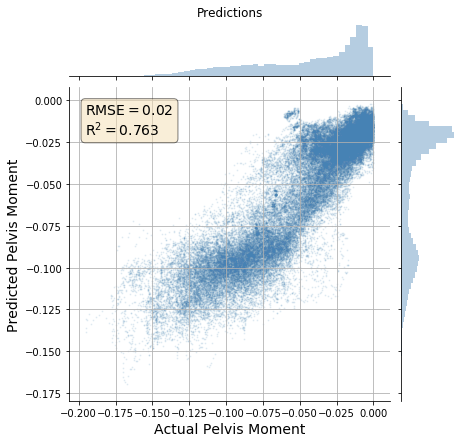

---
**Target**: TF_Pelvis_Moment_X_BWBH  
**Features**: Recipe 4: Real Wearable - All Regular & Exploratory  
**Train/Test**: Subject 2 -> Subject 3  
**Regressor**: Gradient Boosting  
**R2=0.639**

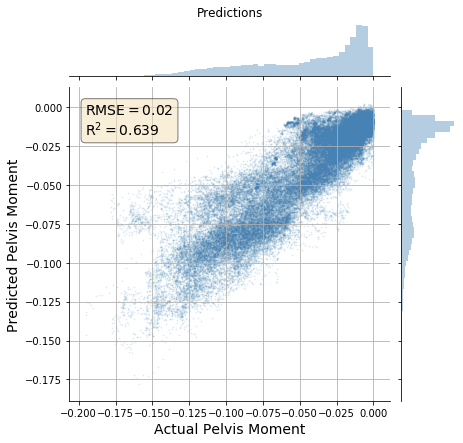

---
**Target**: TF_Pelvis_Moment_X_BWBH  
**Features**: Recipe 5: Real Wearable - Insole Only  
**Train/Test**: Subject 2 -> Subject 3  
**Regressor**: Gradient Boosting  
**R2=-2.877**

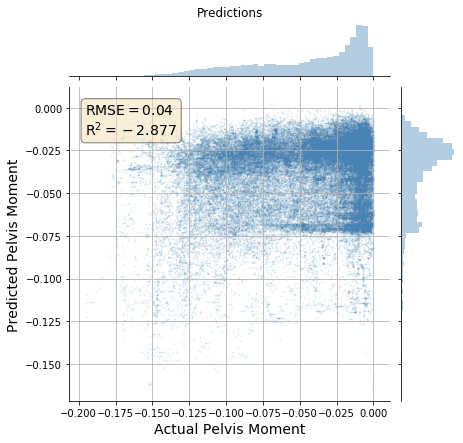

---
**Target**: TF_Pelvis_Moment_X_BWBH  
**Features**: Recipe 6: Real Wearable - Trunk Orientatoin Only  
**Train/Test**: Subject 2 -> Subject 3  
**Regressor**: Gradient Boosting  
**R2=0.733**

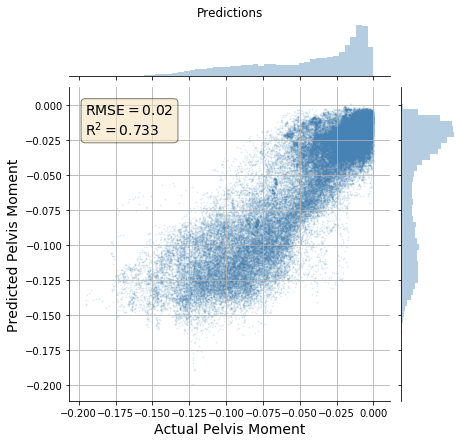

---
**Target**: TF_Pelvis_Moment_X_BWBH  
**Features**: Recipe 7: Real Wearable - Insole & Trunk Orientation  
**Train/Test**: Subject 2 -> Subject 3  
**Regressor**: Gradient Boosting  
**R2=0.671**

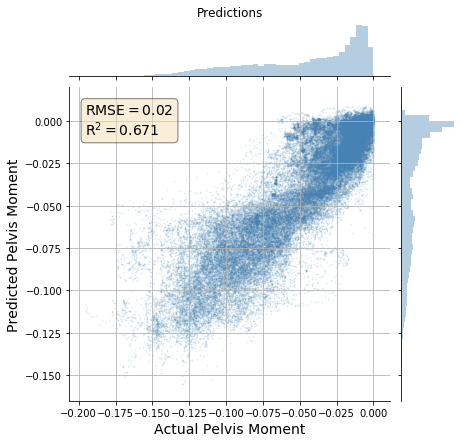

---
**Target**: TF_Pelvis_Moment_X_BWBH  
**Features**: Recipe 8: Real Wearable - Insole & Hip Angles & Trunk Orientation  
**Train/Test**: Subject 2 -> Subject 3  
**Regressor**: Gradient Boosting  
**R2=0.623**

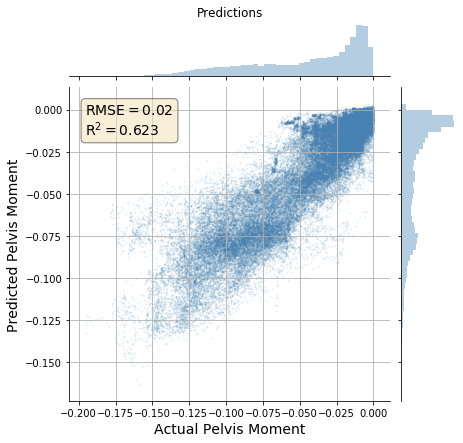

---
**Target**: TF_Pelvis_Moment_X_BWBH  
**Features**: Recipe 3: Real Wearable - All Regular  
**Train/Test**: Subject 3 -> Subject 2  
**Regressor**: Gradient Boosting  
**R2=0.679**

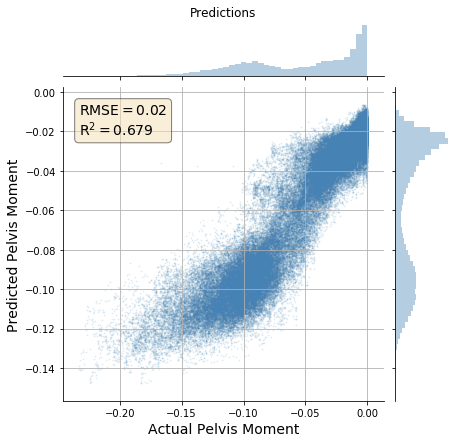

---
**Target**: TF_Pelvis_Moment_X_BWBH  
**Features**: Recipe 4: Real Wearable - All Regular & Exploratory  
**Train/Test**: Subject 3 -> Subject 2  
**Regressor**: Gradient Boosting  
**R2=0.685**

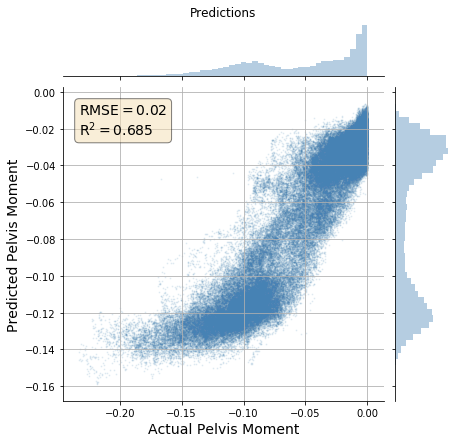

---
**Target**: TF_Pelvis_Moment_X_BWBH  
**Features**: Recipe 5: Real Wearable - Insole Only  
**Train/Test**: Subject 3 -> Subject 2  
**Regressor**: Gradient Boosting  
**R2=-3.470**

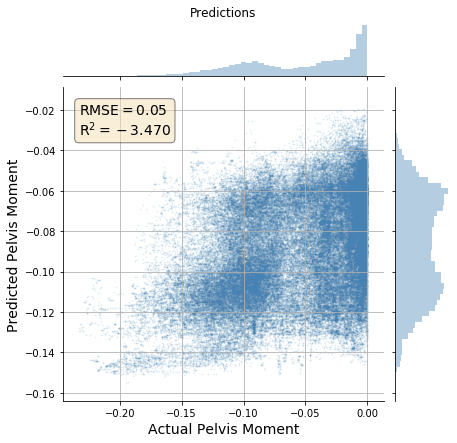

---
**Target**: TF_Pelvis_Moment_X_BWBH  
**Features**: Recipe 6: Real Wearable - Trunk Orientatoin Only  
**Train/Test**: Subject 3 -> Subject 2  
**Regressor**: Gradient Boosting  
**R2=0.612**

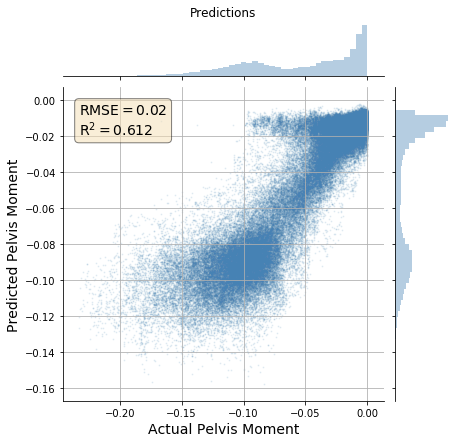

---
**Target**: TF_Pelvis_Moment_X_BWBH  
**Features**: Recipe 7: Real Wearable - Insole & Trunk Orientation  
**Train/Test**: Subject 3 -> Subject 2  
**Regressor**: Gradient Boosting  
**R2=0.620**

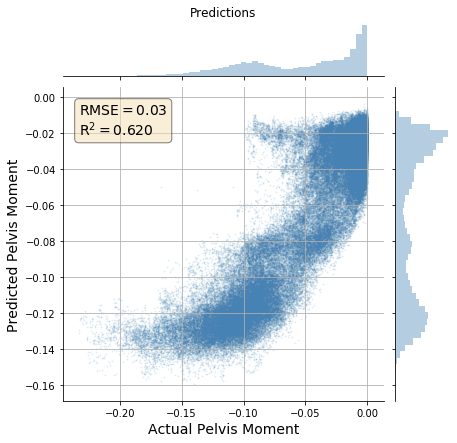

---
**Target**: TF_Pelvis_Moment_X_BWBH  
**Features**: Recipe 8: Real Wearable - Insole & Hip Angles & Trunk Orientation  
**Train/Test**: Subject 3 -> Subject 2  
**Regressor**: Gradient Boosting  
**R2=0.709**

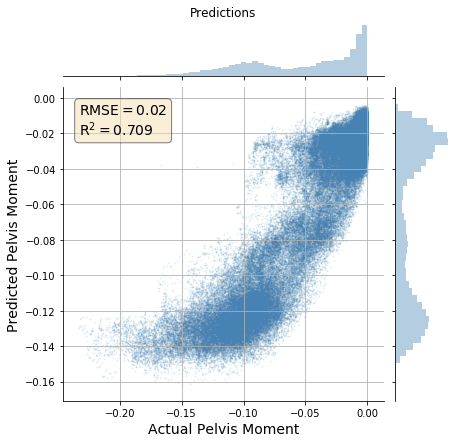

In [27]:
regressors = (
#    ("SGD", "orange", linear_model.SGDRegressor()),
#    ("SGD (Huber)", "red", linear_model.SGDRegressor(loss="huber")),
#    ("SGD (linear SVR)", "green", linear_model.SGDRegressor(loss="epsilon_insensitive")),
#    ("SGD (Lasso)", "black", linear_model.SGDRegressor(penalty="l1")),
#    ("NN", "blue", neural_network.MLPRegressor(hidden_layer_sizes=(100, 50), activation="tanh")),

    ("Gradient Boosting", "steelblue", ensemble.HistGradientBoostingRegressor()),
)
all_r2_scores = {}

for reg_name, reg_color, reg in regressors:
    r2_scores_X, predictions_X = run_experiments("TF_Pelvis_Moment_X_BWBH", 
                                                 train_test_sets, 
                                                 reg, reg_name, 
                                                 reg_color)
    all_r2_scores[reg_name] = r2_scores_X

## Summary Results - show and save

In [28]:
with pd.ExcelWriter('CPAC_S01_S02_S03_05_31_20 - Alternative ML Models.xlsx') as writer:
    for reg_name, r2_scores in all_r2_scores.items():
        r2_table = pd.DataFrame(r2_scores)
        display(Markdown(f"### {reg_name}"))
        display(r2_table)
        r2_table.to_excel(writer, sheet_name=reg_name)

### Gradient Boosting

,Subject 2 -> Subject 3,Subject 3 -> Subject 2
Recipe 3: Real Wearable - All Regular,0.762774,0.678586
Recipe 4: Real Wearable - All Regular & Exploratory,0.638634,0.684887
Recipe 5: Real Wearable - Insole Only,-2.877112,-3.469955
Recipe 6: Real Wearable - Trunk Orientatoin Only,0.732739,0.612082
Recipe 7: Real Wearable - Insole & Trunk Orientation,0.670595,0.619620
Recipe 8: Real Wearable - Insole & Hip Angles & Trunk Orientation,0.622506,0.708631
